<a href="https://colab.research.google.com/github/zhihong1224/CNN_Demo/blob/master/Linear_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Setup

In [0]:
import numpy as np
import torch
from torch import nn,optim
import torch.nn.functional as F
import torch.utils.data as Data
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%matplotlib inline

# 2 准备数据

In [2]:
trans=transforms.ToTensor()
train_data_all=datasets.MNIST(root='./data',train=True,download=True,transform=trans)
test_data=datasets.MNIST(root='./data',train=False,download=True,transform=trans)
len(train_data_all),len(test_data)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


(60000, 10000)

In [3]:
batch_size=128
indices=np.random.permutation(len(train_data_all))
valid_ratio=0.2
valid_num=int(valid_ratio*len(train_data_all))
valid_sampler=SubsetRandomSampler(indices[:valid_num])
train_sampler=SubsetRandomSampler(indices[valid_num:])
train_iter=Data.DataLoader(train_data_all,batch_size=batch_size,sampler=train_sampler,num_workers=4)
valid_iter=Data.DataLoader(train_data_all,batch_size=batch_size,sampler=valid_sampler,num_workers=4)

In [0]:
test_iter=Data.DataLoader(test_data,batch_size=batch_size,num_workers=4)

# 2 数据认知

In [0]:
def show(data_iter,show_num):
  import math
  show_iter=iter(data_iter)
  show_some=next(show_iter)
  img,label=show_some
  fig=plt.figure(figsize=(7,7))
  rows=math.sqrt(show_num)
  cols=math.ceil(show_num/rows)

  for i in range(show_num):
    ax=fig.add_subplot(rows,cols,i+1,xticks=[],yticks=[])
    ax.imshow(img[i].squeeze(),cmap='gray')
    ax.set_title(str(label[i].item()),c='green')

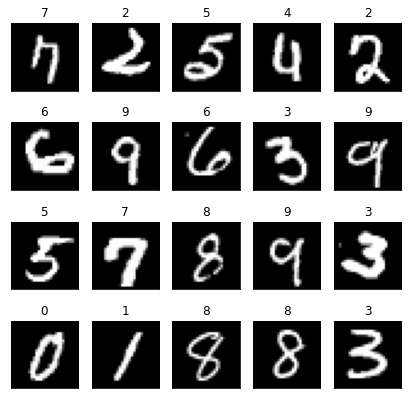

In [6]:
show(train_iter,20)

# 3 自动编码器

In [0]:
class Autoencoder(nn.Module):
  def __init__(self,encoding_dim):
    super(Autoencoder,self).__init__()
    self.fc1=nn.Linear(28*28,encoding_dim)
    self.fc2=nn.Linear(encoding_dim,28*28)
  def forward(self,x):
    x=x.view(x.shape[0],-1)
    x=F.relu(self.fc1(x))
    x=F.sigmoid(self.fc2(x))
    return x

# 4 训练

In [0]:
def train(model,num_epochs,lr,train_iter,valid_iter):
  model=model.to(device)
  criterion=nn.MSELoss()
  optimizer=optim.Adam(model.parameters(),lr)
  train_loss_list,valid_loss_list=[],[]
  valid_min_loss=np.inf
  for epoch in range(num_epochs):
    train_loss,valid_loss=0.0,0.0
    model.train()
    for X,Y in train_iter:
      X=X.to(device)
      Y=Y.to(device)
      y_pred=model(X)
      loss=criterion(y_pred,X.view(X.shape[0],-1))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_loss+=loss.item()*X.shape[0]
      train_loss_list.append(loss.item())
    model.eval()
    for X,Y in valid_iter:
      X=X.to(device)
      Y=Y.to(device)
      y_pred=model(X)
      loss=criterion(y_pred,X.view(X.shape[0],-1))
      valid_loss+=loss.item()*X.shape[0]
      valid_loss_list.append(loss.item())
    train_loss=train_loss/len(train_iter.sampler)
    valid_loss=valid_loss/len(valid_iter.sampler)
    if valid_loss<valid_min_loss:
      print('validation decresed:{}-->{}.saving model...'.\
            format(valid_min_loss,valid_loss))
      torch.save(model.state_dict(),'model.pt')
    print('epoch:{},train loss:{},valid loss:{}'.format(epoch+1,train_loss,valid_loss))
    print('\n')
  return train_loss_list,valid_loss_list

In [15]:
model=Autoencoder(32)
num_epochs,lr=5,0.001
train_loss_list,valid_loss_list=train(model,num_epochs,lr,train_iter,valid_iter)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


validation decresed:inf-->0.040430035024881364.saving model...
epoch:1,train loss:0.06661854927738507,valid loss:0.040430035024881364


validation decresed:inf-->0.030466520259777703.saving model...
epoch:2,train loss:0.03458053255577882,valid loss:0.030466520259777703


validation decresed:inf-->0.02513664549092452.saving model...
epoch:3,train loss:0.027650697658459344,valid loss:0.02513664549092452


validation decresed:inf-->0.021942706376314163.saving model...
epoch:4,train loss:0.023091337124506634,valid loss:0.021942706376314163


validation decresed:inf-->0.0203409281373024.saving model...
epoch:5,train loss:0.020939174170295397,valid loss:0.0203409281373024




# 5 测试

In [0]:
def check(model,data_iter,show_num):
  try:
    show_num<=batch_size
  except:
    print('show_num should be lower than batch_size')
  import math
  show_iter=iter(data_iter)
  show_some=next(show_iter)
  img,label=show_some
  img=img.to(device)
  decoder=model(img)
  fig=plt.figure()
  fig.subplots_adjust(left=0.1,right=0.8,bottom=0.1,top=0.8,hspace=0.05,wspace=0.05)
  for i in range(show_num):
    ax=fig.add_subplot(2,show_num,i+1,xticks=[],yticks=[])
    ax.imshow(img[i].squeeze(0).cpu().numpy(),cmap='gray')
    ax=fig.add_subplot(2,show_num,show_num+i+1,xticks=[],yticks=[])
    ax.imshow(decoder[i].view(28,28).cpu().detach().numpy(),cmap='gray')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


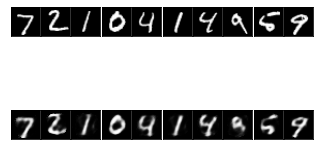

In [39]:
model.load_state_dict(torch.load('model.pt'))
check(model,test_iter,10)